In [79]:
# Multi-Class Attack Detection with Focus on DDoS Attacks
# Using CIC IDS 2017 Dataset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.feature_selection import SelectFromModel
import xgboost as xgb
import catboost as cb
from sklearn.ensemble import StackingClassifier
import shap
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import time
import warnings
warnings.filterwarnings('ignore')

In [80]:
# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")



Using device: cuda


In [81]:
# 1. Data Loading
print("Loading dataset...")

df = pd.read_csv("D:\CIC-IDS-2017CSVs\IDS-2017\Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv")



Loading dataset...


In [82]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225745 entries, 0 to 225744
Data columns (total 85 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   Flow ID                       225745 non-null  object 
 1    Source IP                    225745 non-null  object 
 2    Source Port                  225745 non-null  int64  
 3    Destination IP               225745 non-null  object 
 4    Destination Port             225745 non-null  int64  
 5    Protocol                     225745 non-null  int64  
 6    Timestamp                    225745 non-null  object 
 7    Flow Duration                225745 non-null  int64  
 8    Total Fwd Packets            225745 non-null  int64  
 9    Total Backward Packets       225745 non-null  int64  
 10  Total Length of Fwd Packets   225745 non-null  int64  
 11   Total Length of Bwd Packets  225745 non-null  int64  
 12   Fwd Packet Length Max        225745 non-nul

In [83]:
# 2. Initial Data Exploration
print("\n2. Initial Data Exploration")
print(f"Dataset shape: {df.shape}")
print("\nFirst few rows:")
print(df.head())

print("\nData types:")
print(df.dtypes)

print("\nChecking for missing values:")
print(df.isnull().sum().sum())




2. Initial Data Exploration
Dataset shape: (225745, 85)

First few rows:
                                   Flow ID       Source IP   Source Port  \
0  192.168.10.5-104.16.207.165-54865-443-6  104.16.207.165           443   
1    192.168.10.5-104.16.28.216-55054-80-6   104.16.28.216            80   
2    192.168.10.5-104.16.28.216-55055-80-6   104.16.28.216            80   
3  192.168.10.16-104.17.241.25-46236-443-6   104.17.241.25           443   
4  192.168.10.5-104.19.196.102-54863-443-6  104.19.196.102           443   

   Destination IP   Destination Port   Protocol      Timestamp  \
0    192.168.10.5              54865          6  7/7/2017 3:30   
1    192.168.10.5              55054          6  7/7/2017 3:30   
2    192.168.10.5              55055          6  7/7/2017 3:30   
3   192.168.10.16              46236          6  7/7/2017 3:30   
4    192.168.10.5              54863          6  7/7/2017 3:30   

    Flow Duration   Total Fwd Packets   Total Backward Packets  ...  \
0

In [84]:
# 3. Data Preprocessing
print("\n3. Data Preprocessing")

# 3.1 Handle missing values if any
if df.isnull().sum().sum() > 0:
    print("Handling missing values...")
    # For numeric columns, fill with median
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    for col in numeric_cols:
        df[col].fillna(df[col].median(), inplace=True)
    
    # For categorical columns, fill with mode
    categorical_cols = df.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        df[col].fillna(df[col].mode()[0], inplace=True)

# 3.2 Analyze attack types
print("\nAnalyzing attack types:")
attack_counts = df[' Label'].value_counts()
print(attack_counts)

# 3.3 Create a binary flag for DDoS attacks
print("\nCreating DDoS flag...")
# Check if the label contains 'DDoS' substring
df['is_ddos'] = df[' Label'].str.contains('DDoS', case=False).astype(int)
print(f"DDoS attacks: {df['is_ddos'].sum()} ({df['is_ddos'].mean()*100:.2f}%)")

# 3.4 Encode categorical variables
print("Encoding categorical variables...")
# Identify categorical columns (excluding the target variable)
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
categorical_cols.remove(' Label')  # Remove the target variable

# Encode categorical features if any
if categorical_cols:
    for col in categorical_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])

# 3.5 Encode the target variable
print("Encoding target variable...")
le_target = LabelEncoder()
df['Label_encoded'] = le_target.fit_transform(df[' Label'])
print(f"Target classes: {le_target.classes_}")

# Create a mapping dictionary for reference
label_mapping = {i: label for i, label in enumerate(le_target.classes_)}
print("Label mapping:")
for i, label in label_mapping.items():
    print(f"{i}: {label}")

# 3.6 Separate features and target
X = df.drop(['Flow ID', ' Source IP', ' Destination IP', ' Timestamp', ' Label', 'Label_encoded', 'is_ddos'], axis=1)
y = df['Label_encoded']
y_binary = df['is_ddos']  # For binary DDoS detection

# 3.7 Split the data
print("Splitting data into train and test sets...")
X_train, X_test, y_train, y_test, y_binary_train, y_binary_test = train_test_split(
    X, y, y_binary, test_size=0.2, random_state=42, stratify=y
)

import numpy as np

# Replace inf and -inf with NaN, then fill or drop them
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

# 3.8 Feature scaling
print("Scaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


3. Data Preprocessing
Handling missing values...

Analyzing attack types:
 Label
DDoS      128027
BENIGN     97718
Name: count, dtype: int64

Creating DDoS flag...
DDoS attacks: 128027 (56.71%)
Encoding categorical variables...
Encoding target variable...
Target classes: ['BENIGN' 'DDoS']
Label mapping:
0: BENIGN
1: DDoS
Splitting data into train and test sets...
Scaling features...



4. Exploratory Data Analysis
Class distribution:
Attack distribution plot saved as 'attack_distribution.png'
Calculating feature correlations...
Correlation matrix saved as 'correlation_matrix.png'
Calculating initial feature importance...
Feature importance plot saved as 'feature_importance_all.png'
Calculating feature importance for DDoS attacks...
DDoS feature importance plot saved as 'feature_importance_ddos.png'
Comparing feature distributions for DDoS vs non-DDoS...
DDoS feature distributions saved as 'ddos_feature_distributions.png'


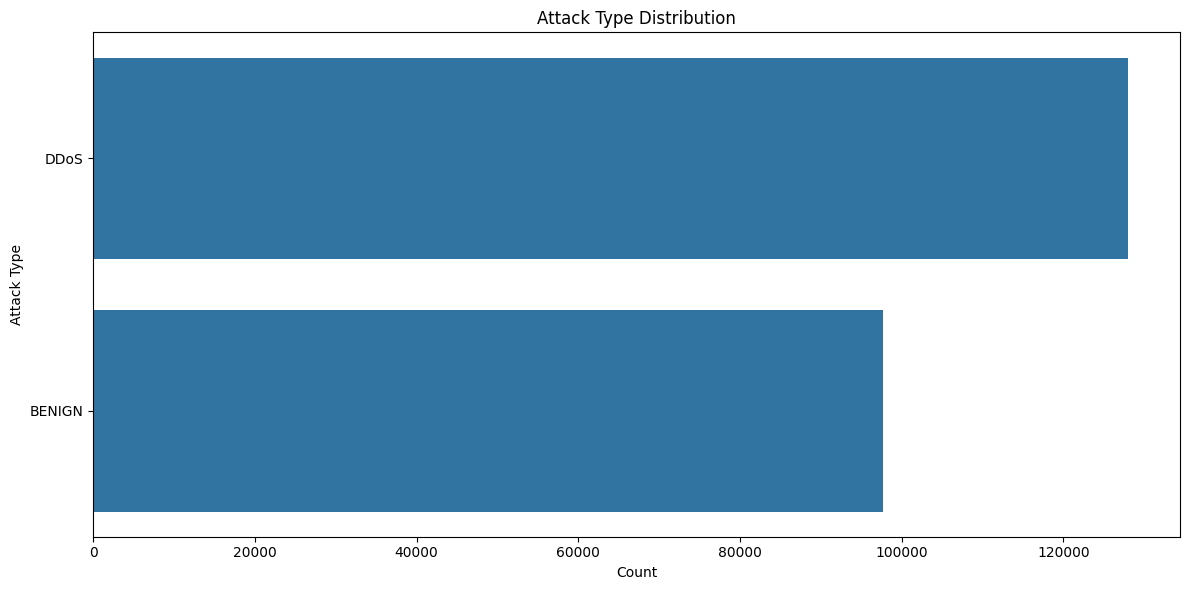

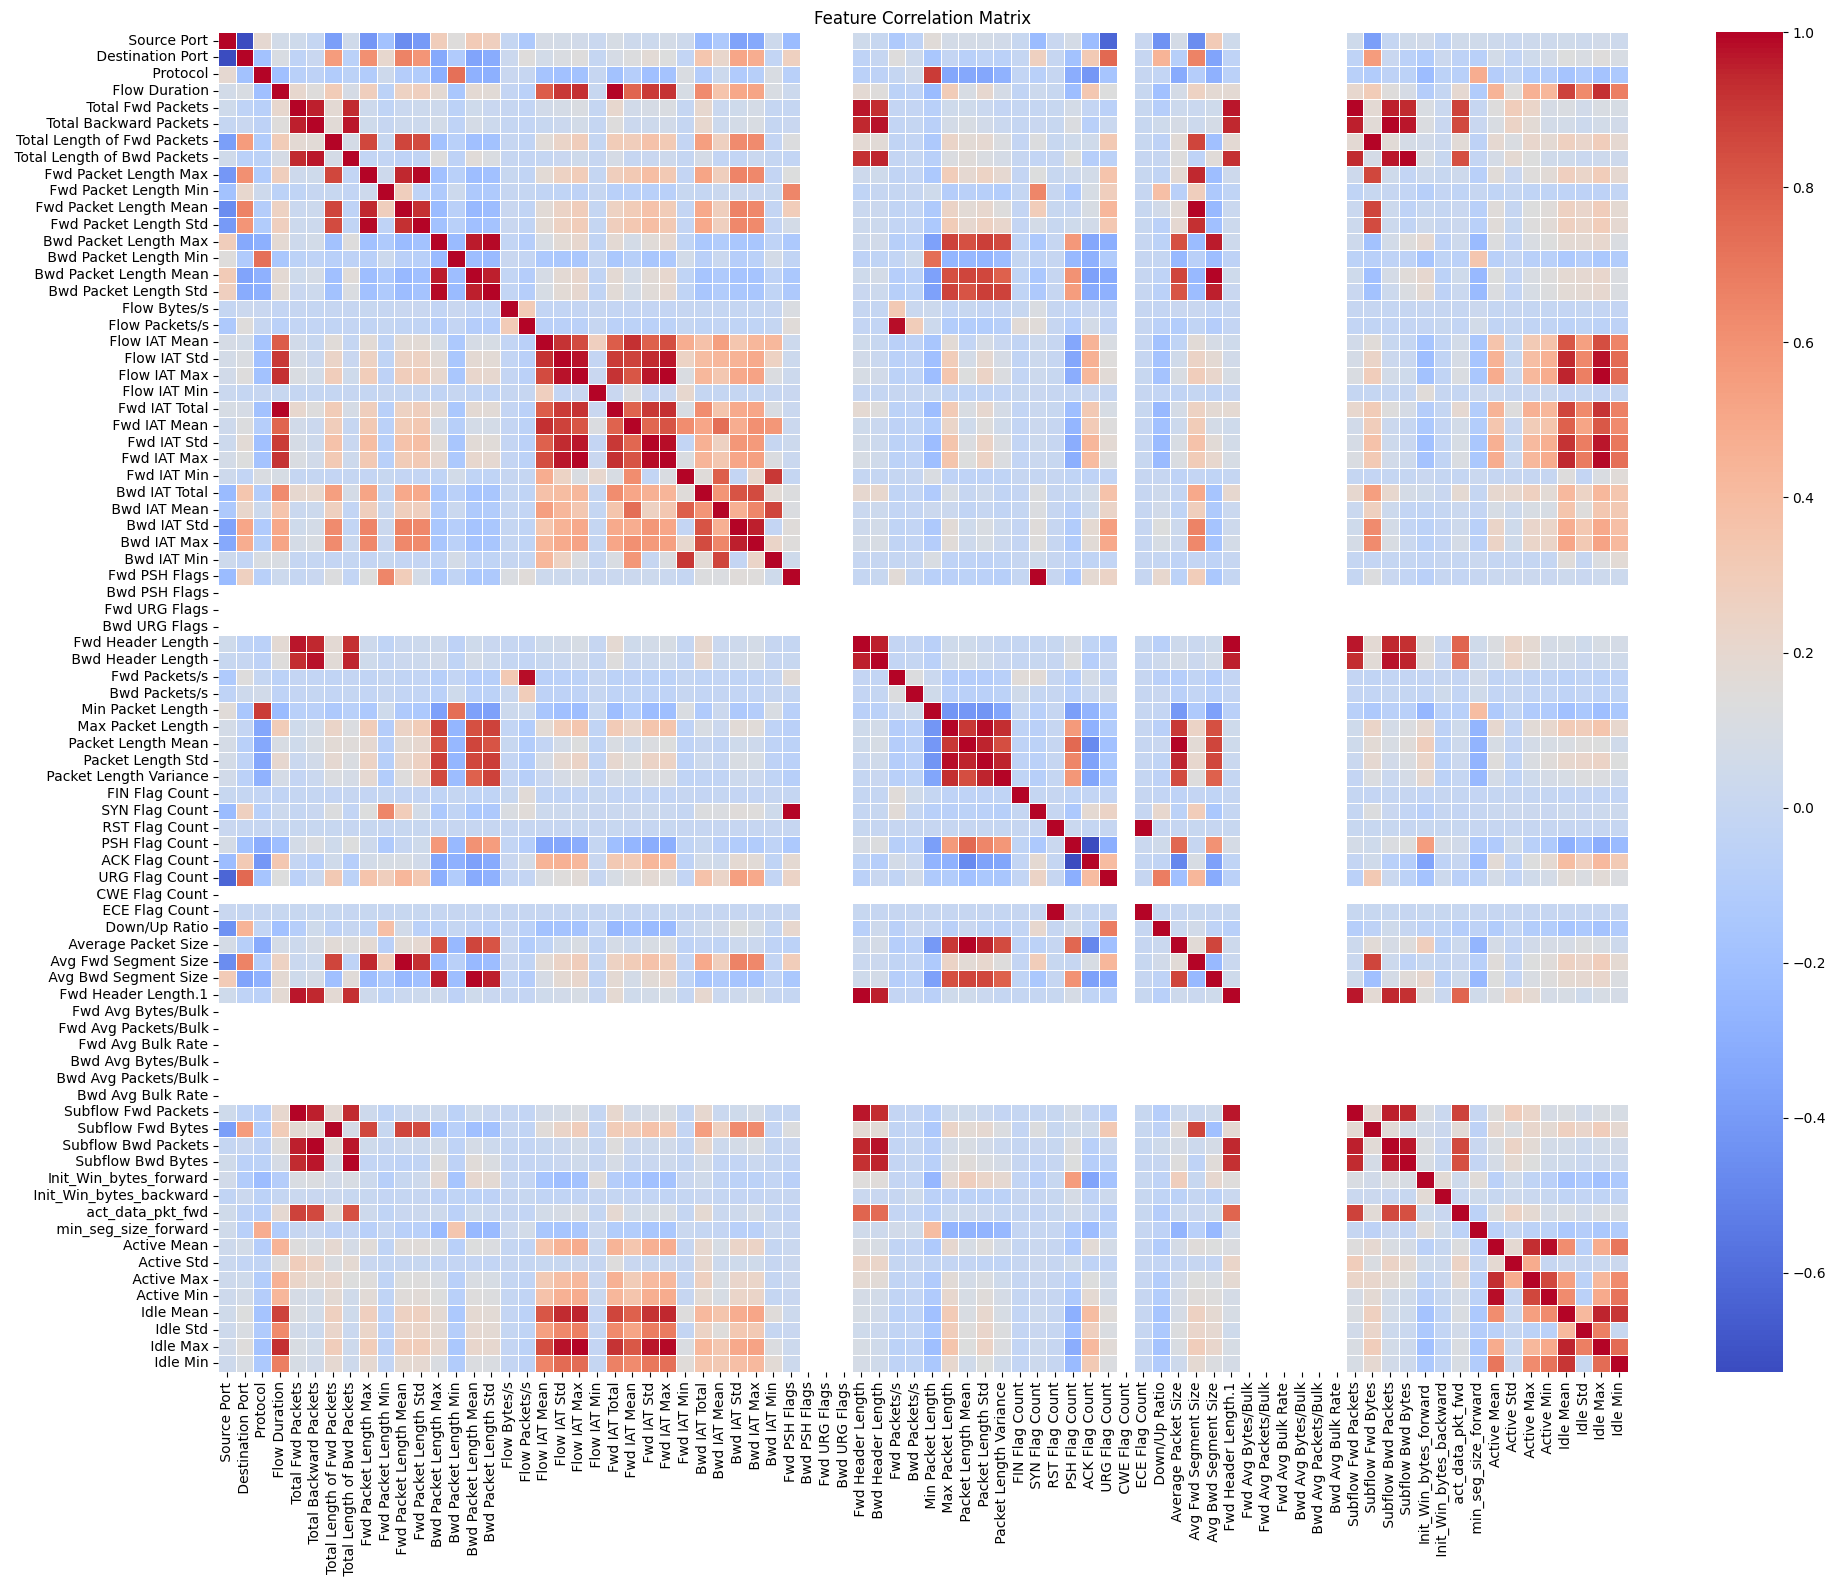

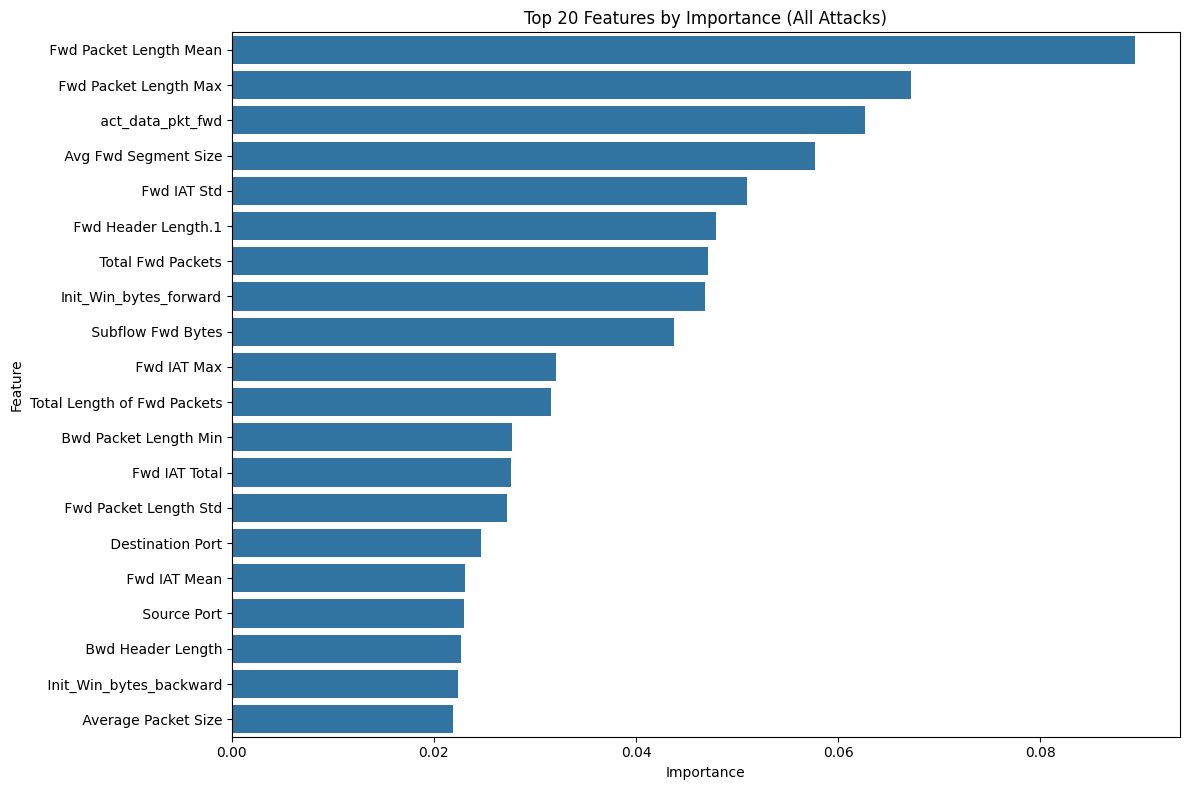

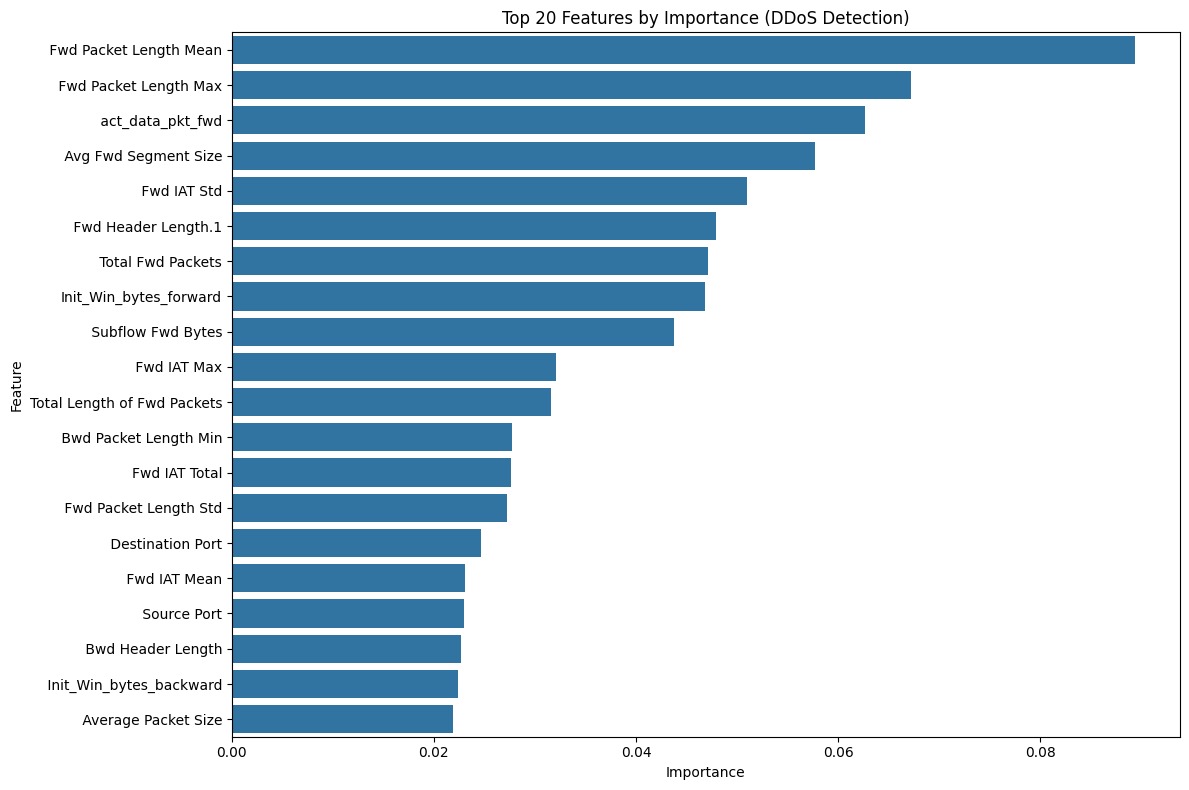

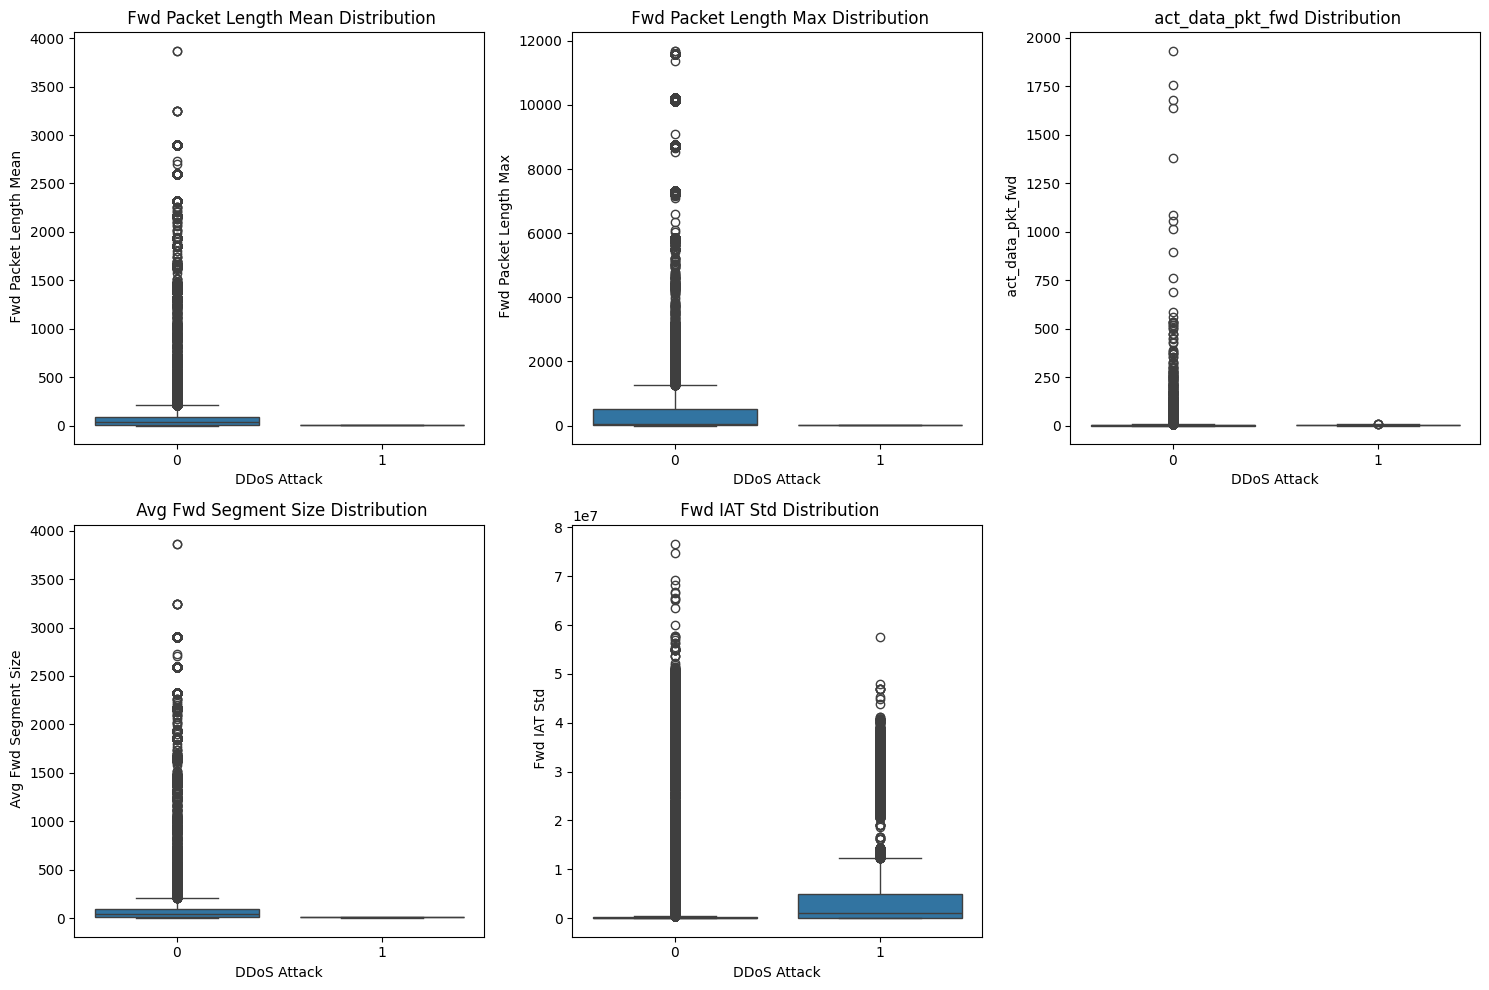

In [85]:
# 4. Exploratory Data Analysis (EDA)
print("\n4. Exploratory Data Analysis")

# 4.1 Class distribution
print("Class distribution:")
plt.figure(figsize=(12, 6))
sns.countplot(y=' Label', data=df, order=df[' Label'].value_counts().index)
plt.title('Attack Type Distribution')
plt.xlabel('Count')
plt.ylabel('Attack Type')
plt.tight_layout()
plt.savefig('attack_distribution.png')
print("Attack distribution plot saved as 'attack_distribution.png'")

# 4.2 Feature correlation
print("Calculating feature correlations...")
plt.figure(figsize=(20, 16))
correlation_matrix = X_train.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.savefig('correlation_matrix.png')
print("Correlation matrix saved as 'correlation_matrix.png'")

# 4.3 Feature importance using Random Forest
print("Calculating initial feature importance...")
# For multi-class classification
rf_initial = RandomForestClassifier(n_estimators=100, random_state=42)
rf_initial.fit(X_train_scaled, y_train)

feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_initial.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(20))
plt.title('Top 20 Features by Importance (All Attacks)')
plt.tight_layout()
plt.savefig('feature_importance_all.png')
print("Feature importance plot saved as 'feature_importance_all.png'")

# 4.4 Feature importance for DDoS specifically
print("Calculating feature importance for DDoS attacks...")
rf_ddos = RandomForestClassifier(n_estimators=100, random_state=42)
rf_ddos.fit(X_train_scaled, y_binary_train)

feature_importance_ddos = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_ddos.feature_importances_
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_ddos.head(20))
plt.title('Top 20 Features by Importance (DDoS Detection)')
plt.tight_layout()
plt.savefig('feature_importance_ddos.png')
print("DDoS feature importance plot saved as 'feature_importance_ddos.png'")

# 4.5 Compare feature distributions for DDoS vs non-DDoS
print("Comparing feature distributions for DDoS vs non-DDoS...")
# Select top 5 important features for DDoS
top_ddos_features = feature_importance_ddos.head(5)['Feature'].tolist()

plt.figure(figsize=(15, 10))
for i, feature in enumerate(top_ddos_features):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x='is_ddos', y=feature, data=df)
    plt.title(f'{feature} Distribution')
    plt.xlabel('DDoS Attack')
    plt.ylabel(feature)

plt.tight_layout()
plt.savefig('ddos_feature_distributions.png')
print("DDoS feature distributions saved as 'ddos_feature_distributions.png'")


5. Feature Selection using SHAP
Calculating SHAP values for DDoS detection...
DDoS SHAP summary plot saved as 'shap_summary_ddos.png'
DDoS SHAP importance plot saved as 'shap_importance_ddos.png'
Attempting SHAP values for all attack types...
SHAP summary plot saved as 'shap_summary_all.png'
Selecting top features based on importance metrics...
Error calculating feature importance from SHAP: Per-column arrays must each be 1-dimensional
Selected 30 top features


<Figure size 1200x800 with 0 Axes>

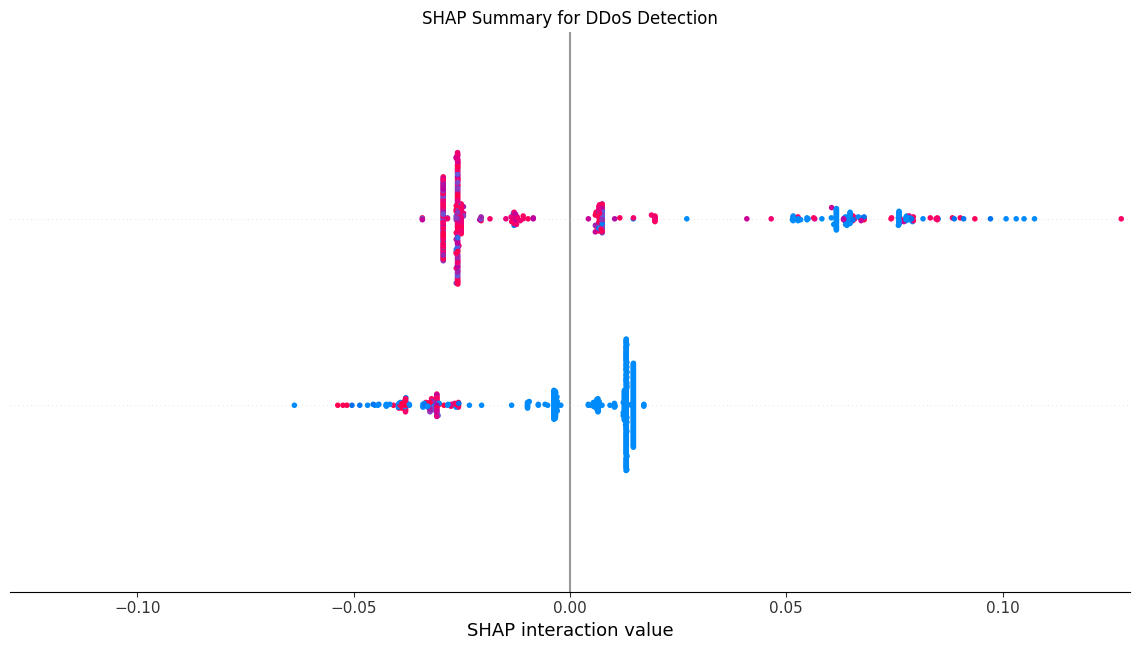

<Figure size 1200x800 with 0 Axes>

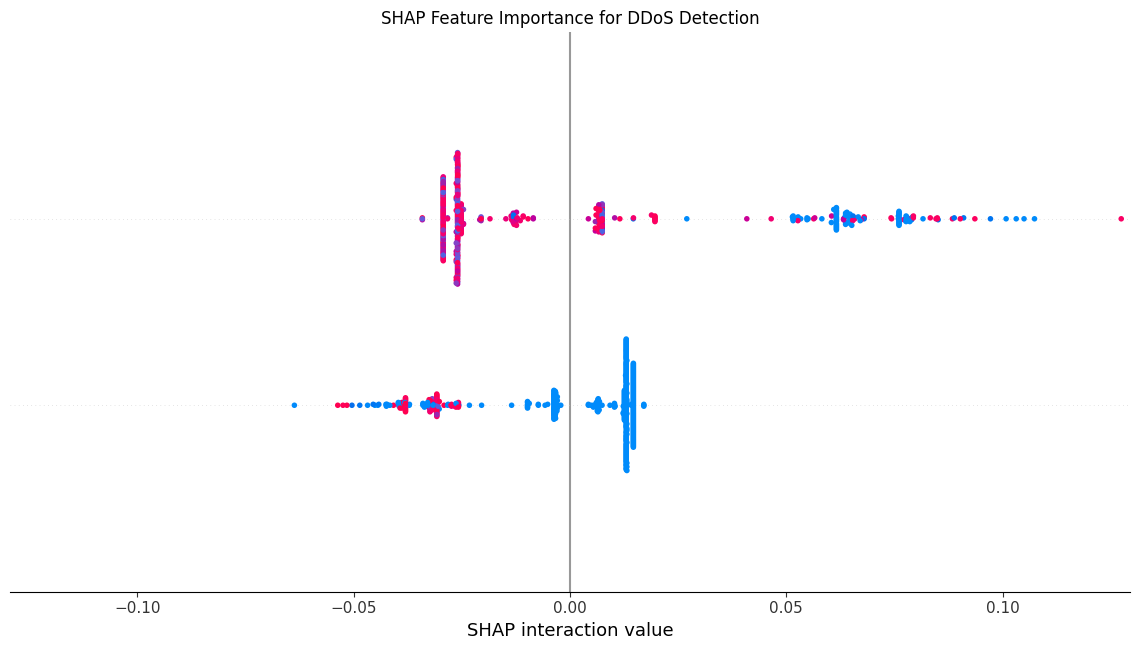

<Figure size 1200x800 with 0 Axes>

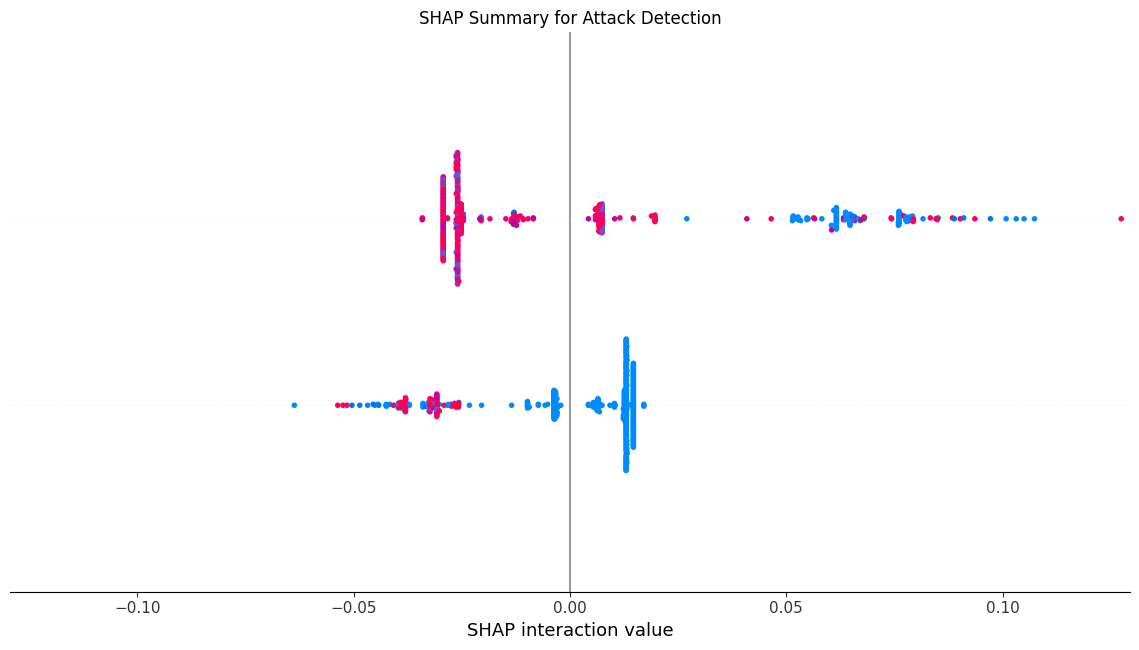

In [86]:
# 5. Feature Selection using SHAP - Fixed Version
print("\n5. Feature Selection using SHAP")
# Use a smaller subset for SHAP analysis to speed up computation
sample_size = min(500, X_train_scaled.shape[0])
X_sample = X_train_scaled[:sample_size]
y_sample = y_train[:sample_size]
y_binary_sample = y_binary_train[:sample_size]

# 5.1 SHAP for binary DDoS classification (more reliable)
print("Calculating SHAP values for DDoS detection...")
model_for_shap_ddos = RandomForestClassifier(n_estimators=100, random_state=42)
model_for_shap_ddos.fit(X_sample, y_binary_sample)

# Create explainer for binary classification
try:
    explainer_ddos = shap.TreeExplainer(model_for_shap_ddos)
    shap_values_ddos = explainer_ddos.shap_values(X_sample)
    
    # Check if shap_values_ddos is a list (for older versions of SHAP)
    if isinstance(shap_values_ddos, list):
        # For binary classification, we typically want the second class (index 1)
        shap_values_to_plot = shap_values_ddos[1] if len(shap_values_ddos) > 1 else shap_values_ddos[0]
    else:
        # For newer versions of SHAP
        shap_values_to_plot = shap_values_ddos
    
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values_to_plot, X_sample, feature_names=X.columns, show=False)
    plt.title('SHAP Summary for DDoS Detection')
    plt.tight_layout()
    plt.savefig('shap_summary_ddos.png')
    print("DDoS SHAP summary plot saved as 'shap_summary_ddos.png'")
    
    # Alternative approach using bar plot (more reliable)
    plt.figure(figsize=(12, 8))
    shap.summary_plot(shap_values_to_plot, X_sample, feature_names=X.columns, plot_type="bar", show=False)
    plt.title('SHAP Feature Importance for DDoS Detection')
    plt.tight_layout()
    plt.savefig('shap_importance_ddos.png')
    print("DDoS SHAP importance plot saved as 'shap_importance_ddos.png'")
    
except Exception as e:
    print(f"Error in SHAP analysis for DDoS detection: {e}")
    print("Falling back to feature importance from Random Forest")
    
    # Fallback to Random Forest feature importance
    feature_importance_ddos = pd.DataFrame({
        'Feature': X.columns,
        'Importance': model_for_shap_ddos.feature_importances_
    }).sort_values(by='Importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_ddos.head(20))
    plt.title('Top 20 Features by Importance (DDoS Detection)')
    plt.tight_layout()
    plt.savefig('feature_importance_ddos.png')
    print("DDoS feature importance plot saved as 'feature_importance_ddos.png'")

# 5.2 Try SHAP for multi-class classification with error handling
print("Attempting SHAP values for all attack types...")
model_for_shap = RandomForestClassifier(n_estimators=100, random_state=42)
model_for_shap.fit(X_sample, y_sample)

try:
    # Try using TreeExplainer for multi-class
    explainer = shap.TreeExplainer(model_for_shap)
    
    # For multi-class, we'll use the first class as an example
    # or aggregate across all classes
    try:
        # First try to get shap values for all classes
        shap_values = explainer.shap_values(X_sample)
        
        # Check if we got a list of shap values (one per class)
        if isinstance(shap_values, list):
            # Plot for the first class as an example
            plt.figure(figsize=(12, 8))
            shap.summary_plot(shap_values[0], X_sample, feature_names=X.columns, show=False)
            plt.title('SHAP Summary for First Attack Class')
            plt.tight_layout()
            plt.savefig('shap_summary_class0.png')
            print("SHAP summary plot for first class saved as 'shap_summary_class0.png'")
            
            # Calculate mean absolute SHAP values across all classes
            all_classes_shap = np.abs(np.array(shap_values)).mean(axis=0)
            
            plt.figure(figsize=(12, 8))
            shap.summary_plot(all_classes_shap, X_sample, feature_names=X.columns, plot_type="bar", show=False)
            plt.title('SHAP Feature Importance Across All Attack Types')
            plt.tight_layout()
            plt.savefig('shap_importance_all.png')
            print("SHAP importance plot for all classes saved as 'shap_importance_all.png'")
        else:
            # For newer versions of SHAP or single output
            plt.figure(figsize=(12, 8))
            shap.summary_plot(shap_values, X_sample, feature_names=X.columns, show=False)
            plt.title('SHAP Summary for Attack Detection')
            plt.tight_layout()
            plt.savefig('shap_summary_all.png')
            print("SHAP summary plot saved as 'shap_summary_all.png'")
    
    except Exception as e:
        print(f"Error in plotting SHAP values: {e}")
        # Try alternative approach with bar plot
        try:
            plt.figure(figsize=(12, 8))
            shap.summary_plot(explainer.shap_values(X_sample), X_sample, 
                             feature_names=X.columns, plot_type="bar", show=False)
            plt.title('SHAP Feature Importance')
            plt.tight_layout()
            plt.savefig('shap_importance_all.png')
            print("SHAP importance plot saved as 'shap_importance_all.png'")
        except:
            raise
            
except Exception as e:
    print(f"Error in SHAP analysis for multi-class: {e}")
    print("Falling back to feature importance from Random Forest")
    
    # Fallback to Random Forest feature importance
    feature_importance = pd.DataFrame({
        'Feature': X.columns,
        'Importance': model_for_shap.feature_importances_
    }).sort_values(by='Importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(20))
    plt.title('Top 20 Features by Importance (All Attacks)')
    plt.tight_layout()
    plt.savefig('feature_importance_all.png')
    print("Feature importance plot saved as 'feature_importance_all.png'")

# Select top features based on available importance metrics
print("Selecting top features based on importance metrics...")

# Initialize feature importance dataframes
feature_importance_shap = None
feature_importance_shap_ddos = None

# Try to use SHAP values if available
try:
    if 'shap_values' in locals() and isinstance(shap_values, list):
        # For multi-class
        mean_abs_shap = np.mean([np.abs(sv) for sv in shap_values], axis=0)
        feature_importance_shap = pd.DataFrame({
            'Feature': X.columns,
            'Importance': mean_abs_shap.mean(axis=0)
        }).sort_values(by='Importance', ascending=False)
    
    if 'shap_values_ddos' in locals():
        # For binary DDoS classification
        if isinstance(shap_values_ddos, list):
            mean_abs_shap_ddos = np.mean(np.abs(shap_values_ddos[1] if len(shap_values_ddos) > 1 else shap_values_ddos[0]), axis=0)
        else:
            mean_abs_shap_ddos = np.mean(np.abs(shap_values_ddos), axis=0)
            
        feature_importance_shap_ddos = pd.DataFrame({
            'Feature': X.columns,
            'Importance': mean_abs_shap_ddos
        }).sort_values(by='Importance', ascending=False)
except Exception as e:
    print(f"Error calculating feature importance from SHAP: {e}")

# If SHAP failed, use Random Forest feature importance
if feature_importance_shap is None:
    feature_importance_shap = pd.DataFrame({
        'Feature': X.columns,
        'Importance': model_for_shap.feature_importances_
    }).sort_values(by='Importance', ascending=False)

if feature_importance_shap_ddos is None:
    feature_importance_shap_ddos = pd.DataFrame({
        'Feature': X.columns,
        'Importance': model_for_shap_ddos.feature_importances_
    }).sort_values(by='Importance', ascending=False)

# Select top 30 features for multi-class and DDoS
top_features = feature_importance_shap.head(30)['Feature'].tolist()
top_features_ddos = feature_importance_shap_ddos.head(30)['Feature'].tolist()

# Combine the top features from both analyses
combined_features = list(set(top_features + top_features_ddos))
print(f"Selected {len(combined_features)} top features")

# Filter the dataset to include only the selected features
X_train_selected = X_train[combined_features]
X_test_selected = X_test[combined_features]

# Scale the selected features
X_train_selected_scaled = scaler.fit_transform(X_train_selected)
X_test_selected_scaled = scaler.transform(X_test_selected)

In [87]:
print("Top features (combined):")
print(combined_features)


Top features (combined):
[' Destination Port', ' Fwd IAT Max', 'Total Length of Fwd Packets', ' Fwd Packet Length Max', ' Fwd IAT Std', ' Bwd Packet Length Min', ' Source Port', 'Subflow Fwd Packets', ' Bwd Header Length', ' Fwd Header Length', 'Bwd Packet Length Max', ' Total Backward Packets', ' Bwd Packet Length Mean', ' Fwd IAT Mean', ' act_data_pkt_fwd', ' Total Length of Bwd Packets', ' Avg Fwd Segment Size', ' Total Fwd Packets', ' Subflow Fwd Bytes', ' Fwd Packet Length Mean', ' Fwd Header Length.1', 'Init_Win_bytes_forward', ' Subflow Bwd Bytes', 'Bwd IAT Total', ' Average Packet Size', 'Fwd IAT Total', ' Avg Bwd Segment Size', ' Fwd Packet Length Std', ' Packet Length Variance', ' Bwd Packet Length Std']


In [88]:
# 6. Model Building and Evaluation
print("\n6. Model Building and Evaluation")

# Function to evaluate model performance
def evaluate_model(y_true, y_pred, y_prob=None):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    # Calculate ROC AUC if probabilities are provided
    roc_auc = None
    if y_prob is not None:
        try:
            roc_auc = roc_auc_score(y_true, y_prob)
        except:
            roc_auc = None
    
    # Create confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc,
        'confusion_matrix': cm
    }

# Dictionary to store model results
model_results = {}




6. Model Building and Evaluation


In [89]:
# 6.1 Random Forest
print("\n6.1 Training Random Forest...")
start_time = time.time()
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train_selected_scaled, y_train)
rf_pred = rf_model.predict(X_test_selected_scaled)
# Handle single-class case for predict_proba
if rf_model.n_classes_ == 1:
	# Only one class present, probability is always 1 for that class
	rf_prob = np.ones_like(rf_pred, dtype=float)
else:
	rf_prob = rf_model.predict_proba(X_test_selected_scaled)[:, 1]
rf_time = time.time() - start_time

rf_results = evaluate_model(y_test, rf_pred, rf_prob)
rf_results['training_time'] = rf_time
model_results['Random Forest'] = rf_results

print(f"Random Forest Results:")
print(f"Accuracy: {rf_results['accuracy']:.4f}")
print(f"Precision: {rf_results['precision']:.4f}")
print(f"Recall: {rf_results['recall']:.4f}")
print(f"F1 Score: {rf_results['f1_score']:.4f}")
print(f"ROC AUC: {rf_results['roc_auc']:.4f}")
print(f"Training Time: {rf_results['training_time']:.2f} seconds")




6.1 Training Random Forest...
Random Forest Results:
Accuracy: 0.9999
Precision: 0.9999
Recall: 0.9999
F1 Score: 0.9999
ROC AUC: 1.0000
Training Time: 8.49 seconds


In [90]:
# 6.2 SVM
print("\n6.2 Training SVM...")
start_time = time.time()
svm_model = SVC(kernel='rbf', probability=True, random_state=42)
svm_model.fit(X_train_selected_scaled, y_train)
svm_pred = svm_model.predict(X_test_selected_scaled)
svm_prob = svm_model.predict_proba(X_test_selected_scaled)[:, 1]
svm_time = time.time() - start_time

svm_results = evaluate_model(y_test, svm_pred, svm_prob)
svm_results['training_time'] = svm_time
model_results['SVM'] = svm_results

print(f"SVM Results:")
print(f"Accuracy: {svm_results['accuracy']:.4f}")
print(f"Precision: {svm_results['precision']:.4f}")
print(f"Recall: {svm_results['recall']:.4f}")
print(f"F1 Score: {svm_results['f1_score']:.4f}")
print(f"ROC AUC: {svm_results['roc_auc']:.4f}")
print(f"Training Time: {svm_results['training_time']:.2f} seconds")




6.2 Training SVM...
SVM Results:
Accuracy: 0.9981
Precision: 0.9981
Recall: 0.9981
F1 Score: 0.9981
ROC AUC: 0.9993
Training Time: 1134.05 seconds


In [91]:
# 6.3 Neural Network with PyTorch
print("\n6.3 Training Neural Network with PyTorch...")

# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_selected_scaled).to(device)
y_train_tensor = torch.LongTensor(y_train.values).to(device)
X_test_tensor = torch.FloatTensor(X_test_selected_scaled).to(device)

# Create DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Define the neural network
class DDoSNet(nn.Module):
    def __init__(self, input_size):
        super(DDoSNet, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 2)  # Binary classification
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Initialize the model
input_size = X_train_selected_scaled.shape[1]
nn_model = DDoSNet(input_size).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(nn_model.parameters(), lr=0.001)

# Train the model
start_time = time.time()
epochs = 10
for epoch in range(epochs):
    nn_model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = nn_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    if (epoch + 1) % 2 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}")

# Evaluate the model
nn_model.eval()
with torch.no_grad():
    outputs = nn_model(X_test_tensor)
    _, nn_pred = torch.max(outputs, 1)
    nn_prob = torch.softmax(outputs, dim=1)[:, 1]
    
    nn_pred = nn_pred.cpu().numpy()
    nn_prob = nn_prob.cpu().numpy()

nn_time = time.time() - start_time

nn_results = evaluate_model(y_test, nn_pred, nn_prob)
nn_results['training_time'] = nn_time
model_results['Neural Network'] = nn_results

print(f"Neural Network Results:")
print(f"Accuracy: {nn_results['accuracy']:.4f}")
print(f"Precision: {nn_results['precision']:.4f}")
print(f"Recall: {nn_results['recall']:.4f}")
print(f"F1 Score: {nn_results['f1_score']:.4f}")
print(f"ROC AUC: {nn_results['roc_auc']:.4f}")
print(f"Training Time: {nn_results['training_time']:.2f} seconds")




6.3 Training Neural Network with PyTorch...
Epoch 2/10, Loss: 0.0063
Epoch 4/10, Loss: 0.0056
Epoch 6/10, Loss: 0.0053
Epoch 8/10, Loss: 0.0045
Epoch 10/10, Loss: 0.0046
Neural Network Results:
Accuracy: 0.9992
Precision: 0.9992
Recall: 0.9992
F1 Score: 0.9992
ROC AUC: 1.0000
Training Time: 113.29 seconds


In [92]:
# 6.4 XGBoost
#print("\n6.4 Training XGBoost...")
#start_time = time.time()
#xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss')
#xgb_model.fit(X_train_selected_scaled, y_train)
#xgb_pred = xgb_model.predict(X_test_selected_scaled)
#xgb_prob = xgb_model.predict_proba(X_test_selected_scaled)[:, 1]
#xgb_time = time.time() - start_time

#xgb_results = evaluate_model(y_test, xgb_pred, xgb_prob)
#xgb_results['training_time'] = xgb_time
#model_results['XGBoost'] = xgb_results

#print(f"XGBoost Results:")
#print(f"Accuracy: {xgb_results['accuracy']:.4f}")
#print(f"Precision: {xgb_results['precision']:.4f}")
#print(f"Recall: {xgb_results['recall']:.4f}")
#print(f"F1 Score: {xgb_results['f1_score']:.4f}")
#print(f"ROC AUC: {xgb_results['roc_auc']:.4f}")
#print(f"Training Time: {xgb_results['training_time']:.2f} seconds")



In [93]:
# 6.5 CatBoost
#print("\n6.5 Training CatBoost...")
#start_time = time.time()
#cb_model = cb.CatBoostClassifier(iterations=100, random_state=42, verbose=0)
#cb_model.fit(X_train_selected_scaled, y_train)
#cb_pred = cb_model.predict(X_test_selected_scaled)
#cb_prob = cb_model.predict_proba(X_test_selected_scaled)[:, 1]
#cb_time = time.time() - start_time

#cb_results = evaluate_model(y_test, cb_pred, cb_prob)
#cb_results['training_time'] = cb_time
#model_results['CatBoost'] = cb_results

#print(f"CatBoost Results:")
#print(f"Accuracy: {cb_results['accuracy']:.4f}")
#print(f"Precision: {cb_results['precision']:.4f}")
#print(f"Recall: {cb_results['recall']:.4f}")
#print(f"F1 Score: {cb_results['f1_score']:.4f}")
#print(f"ROC AUC: {cb_results['roc_auc']:.4f}")
#print(f"Training Time: {cb_results['training_time']:.2f} seconds")



In [94]:
# 6.6 Stacking Classifier (XGBoost + CatBoost)
print("\n6.6 Training Stacking Classifier (XGBoost + CatBoost)...")
start_time = time.time()

# Define base models
base_models = [
    ('xgb', xgb.XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='logloss')),
    ('catboost', cb.CatBoostClassifier(iterations=100, random_state=42, verbose=0))
]

# Define meta-learner
meta_learner = RandomForestClassifier(n_estimators=100, random_state=42)

# Create stacking classifier
stacking_model = StackingClassifier(
    estimators=base_models,
    final_estimator=meta_learner,
    cv=5
)

# Train stacking classifier
stacking_model.fit(X_train_selected_scaled, y_train)
stacking_pred = stacking_model.predict(X_test_selected_scaled)
stacking_prob = stacking_model.predict_proba(X_test_selected_scaled)[:, 1]
stacking_time = time.time() - start_time

stacking_results = evaluate_model(y_test, stacking_pred, stacking_prob)
stacking_results['training_time'] = stacking_time
model_results['KC-CIC'] = stacking_results

print(f"KC-CIC Results:")
print(f"Accuracy: {stacking_results['accuracy']:.4f}")
print(f"Precision: {stacking_results['precision']:.4f}")
print(f"Recall: {stacking_results['recall']:.4f}")
print(f"F1 Score: {stacking_results['f1_score']:.4f}")
print(f"ROC AUC: {stacking_results['roc_auc']:.4f}")
print(f"Training Time: {stacking_results['training_time']:.2f} seconds")




6.6 Training Stacking Classifier (XGBoost + CatBoost)...
KC-CIC Results:
Accuracy: 0.9999
Precision: 0.9999
Recall: 0.9999
F1 Score: 0.9999
ROC AUC: 1.0000
Training Time: 34.75 seconds



7. Model Comparison
            Model  Accuracy  Precision    Recall  F1 Score   ROC AUC  \
0   Random Forest  0.999867   0.999867  0.999867  0.999867  0.999980   
1             SVM  0.998117   0.998118  0.998117  0.998117  0.999298   
2  Neural Network  0.999203   0.999203  0.999203  0.999203  0.999981   
3          KC-CIC  0.999911   0.999911  0.999911  0.999911  0.999980   

   Training Time (s)  
0           8.490422  
1        1134.048257  
2         113.288245  
3          34.747606  
Model comparison plot saved as 'model_comparison.png'


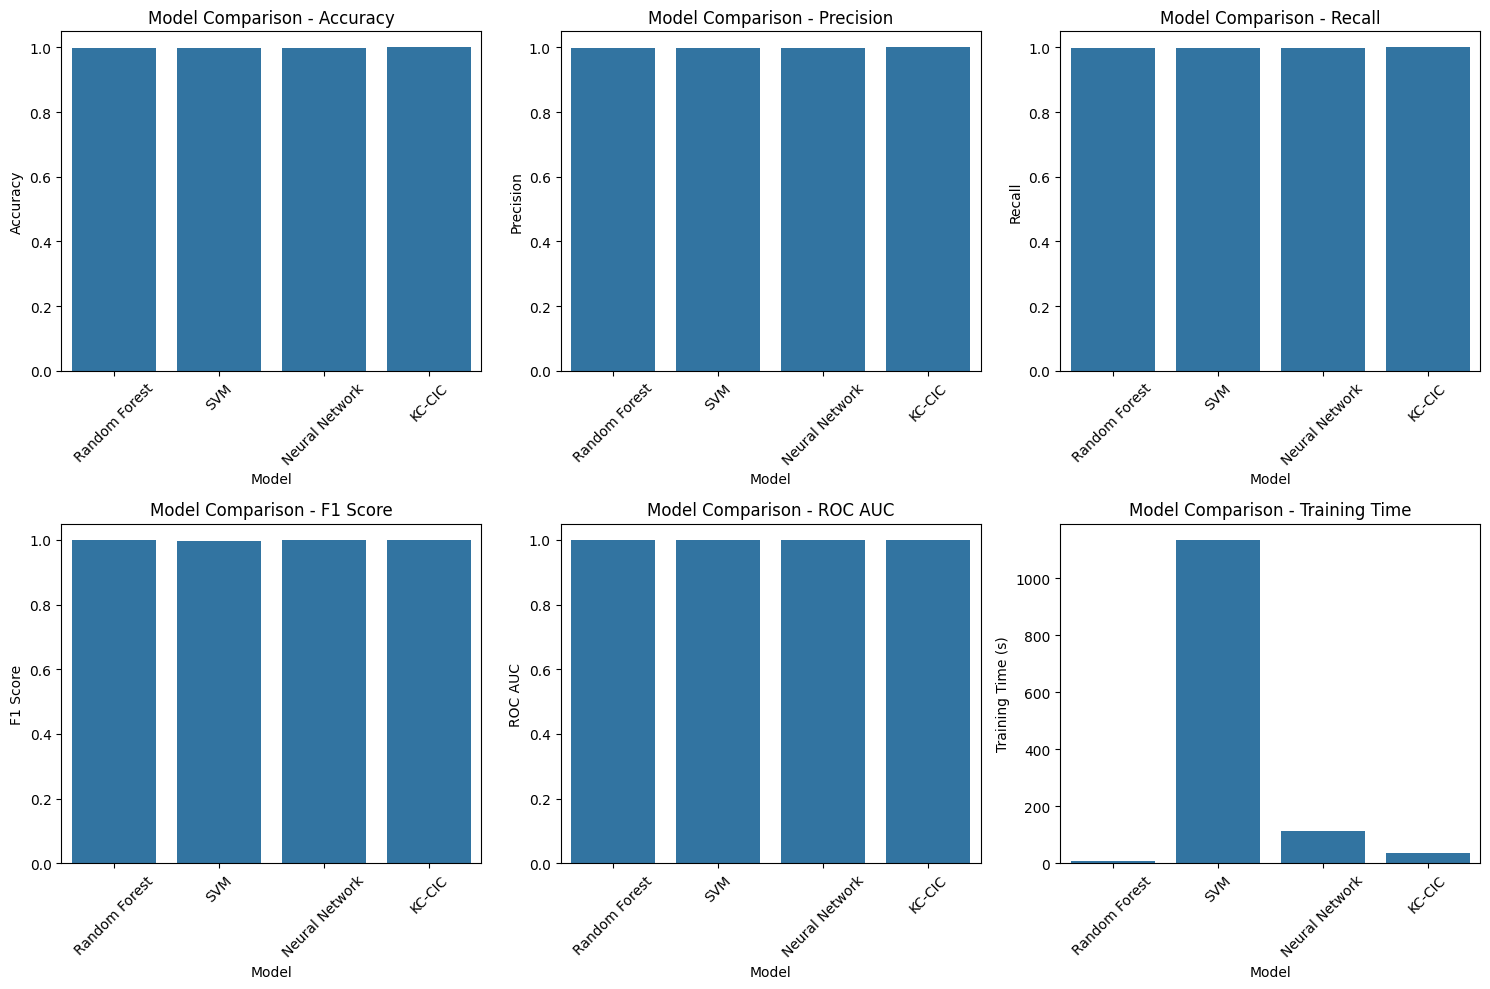

In [95]:
# 7. Model Comparison
print("\n7. Model Comparison")

# Create a comparison table
comparison_df = pd.DataFrame({
    'Model': list(model_results.keys()),
    'Accuracy': [results['accuracy'] for results in model_results.values()],
    'Precision': [results['precision'] for results in model_results.values()],
    'Recall': [results['recall'] for results in model_results.values()],
    'F1 Score': [results['f1_score'] for results in model_results.values()],
    'ROC AUC': [results['roc_auc'] for results in model_results.values()],
    'Training Time (s)': [results['training_time'] for results in model_results.values()]
})

print(comparison_df)

# Plot model comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC']
plt.figure(figsize=(15, 10))

for i, metric in enumerate(metrics):
    plt.subplot(2, 3, i+1)
    sns.barplot(x='Model', y=metric, data=comparison_df)
    plt.title(f'Model Comparison - {metric}')
    plt.xticks(rotation=45)
    plt.tight_layout()

plt.subplot(2, 3, 6)
sns.barplot(x='Model', y='Training Time (s)', data=comparison_df)
plt.title('Model Comparison - Training Time')
plt.xticks(rotation=45)
plt.tight_layout()

plt.savefig('model_comparison.png')
print("Model comparison plot saved as 'model_comparison.png'")




8. Confusion Matrices
Confusion matrices saved as 'confusion_matrices.png'

9. Conclusion
Best model based on F1 Score: KC-CIC with F1 Score of 0.9999

DDoS Detection Pipeline Complete!
All visualizations have been saved as PNG files.


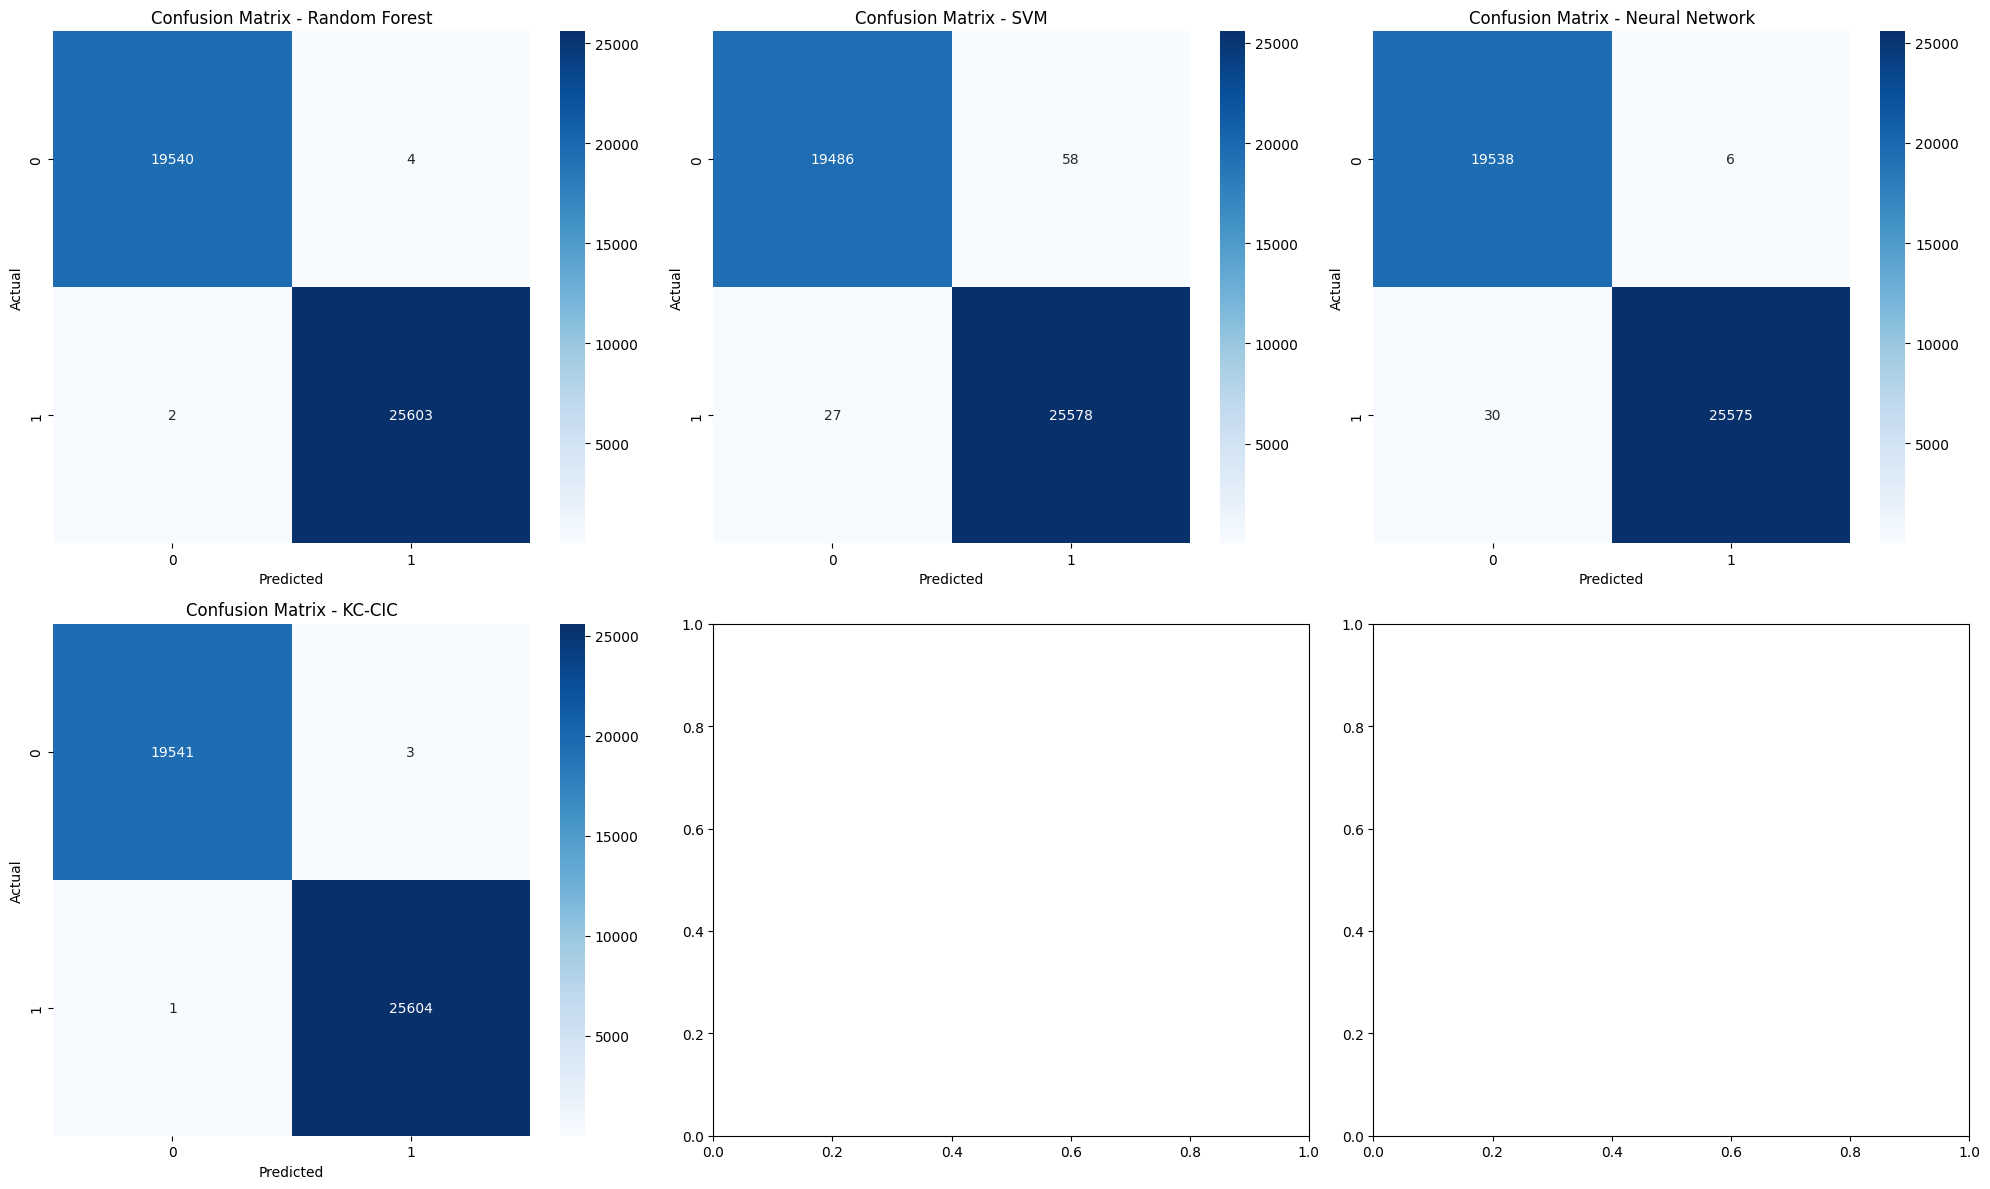

In [96]:
# 8. Confusion Matrices
print("\n8. Confusion Matrices")
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for i, (model_name, results) in enumerate(model_results.items()):
    cm = results['confusion_matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i])
    axes[i].set_title(f'Confusion Matrix - {model_name}')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')

plt.tight_layout()
plt.savefig('confusion_matrices.png')
print("Confusion matrices saved as 'confusion_matrices.png'")

# 9. Conclusion
print("\n9. Conclusion")
best_model = comparison_df.loc[comparison_df['F1 Score'].idxmax()]
print(f"Best model based on F1 Score: {best_model['Model']} with F1 Score of {best_model['F1 Score']:.4f}")

print("\nDDoS Detection Pipeline Complete!")
print("All visualizations have been saved as PNG files.")